# SVC for CPI prediction

In [365]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


In [366]:
# Load the dataset
monthly_data = pd.read_csv('Monthly_data.csv')

# Define the lag for predicting future CPI values
lag = 1
column_name = f'Indicator {lag} Month{"s" if lag > 1 else ""} ahead'

# Create a new column in the dataset for the target variable,
# where 1 indicates CPI increase, and -1 indicates decrease or no change.
monthly_data[column_name] = np.where(
    (monthly_data['CPI'].shift(-lag) - monthly_data['CPI']) > 0, 1, -1)

# Handling data for prediction: select the last 'lag' months for prediction
final_data = monthly_data.iloc[-lag:, :]

# Preprocessing steps: replace infinity with NaN, then drop missing values
monthly_data.replace(np.inf, np.nan, inplace=True)
monthly_data.dropna(inplace=True)

# Select input features for the model
input_variables = monthly_data[['CPI','Interest rate', 'GDP growth', 'Total pay nominal', 'Unemployment', '12 Month MA - current', 'M3 growth', 'USD/GBP', 'Brent']]

# Select features from final_data for future prediction (demonstration)
prediction_variables = final_data[['CPI','Interest rate', 'GDP growth', 'Total pay nominal', 'Unemployment', '12 Month MA - current', 'M3 growth', 'USD/GBP', 'Brent']]

# Select the output target variable
output_variable = monthly_data.iloc[:, -1]

# Normalize the input variables using StandardScaler for better performance
scaler = StandardScaler()
input_variables_scaled = scaler.fit_transform(input_variables)
prediction_variables_scaled = scaler.transform(prediction_variables)

# Note: The normalization process standardizes the feature data which can improve the performance
# and convergence speed of many machine learning algorithms.

Best parameters: {'C': 100, 'gamma': 0.01}
Test Accuracy with best parameters: 0.6415094339622641


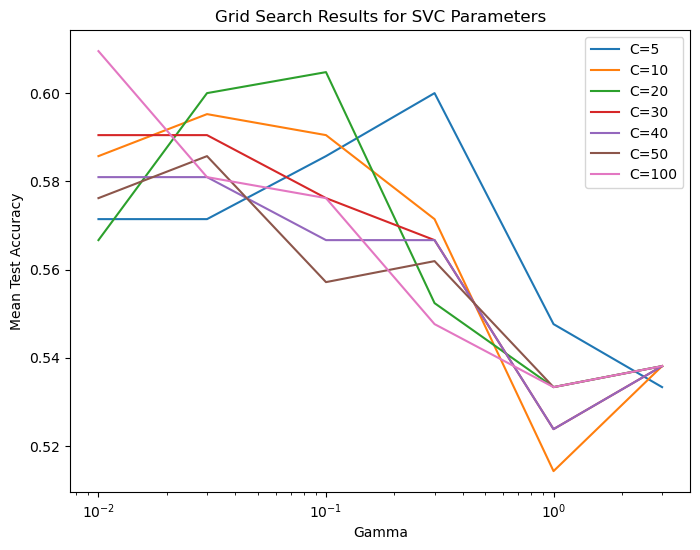

In [367]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_variables_scaled, output_variable.values.ravel(), test_size=0.2)

# Defining the parameter grid to search for the best parameters for SVC
param_grid = {
    'C': [5, 10, 20, 30, 40, 50, 100],  # Regularization parameter
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3],  # Kernel coefficient for 'rbf'
}

# Setting up the grid search for SVC with RBF kernel
svm_model = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_model, param_grid, cv=10, scoring='accuracy')

# Performing the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Outputting the best parameters and the accuracy of the best model
print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with best parameters: {test_accuracy}")

# Visualization of the grid search results
results = grid_search.cv_results_
scores_mean = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

# Plotting accuracy as a function of gamma for each value of C
plt.figure(figsize=(8, 6))
for i, C in enumerate(param_grid['C']):
    plt.plot(param_grid['gamma'], scores_mean[i], label=f'C={C}')

plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Results for SVC Parameters')
plt.xscale('log')  # Using logarithmic scale for better visualization of gamma values
plt.show()

# This visualization helps in understanding how the SVM model's performance varies with different
# values of 'C' and 'gamma', aiding in the selection of the best parameters for the model.


Best parameters: {'C': 20, 'gamma': 0.005}


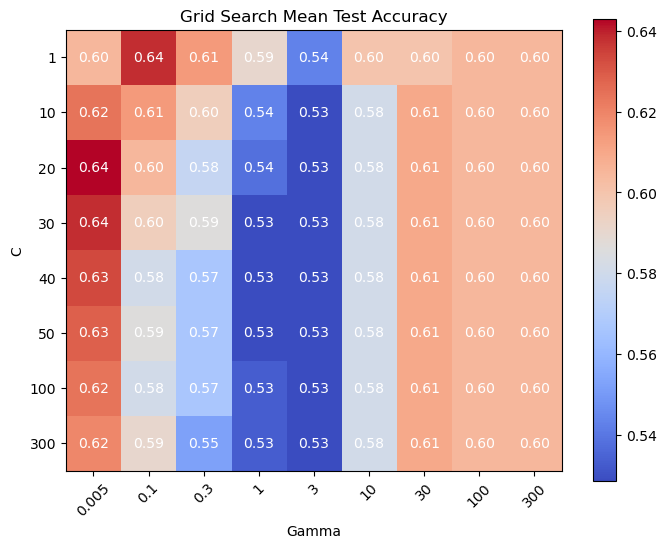

In [368]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_variables_scaled, output_variable, test_size=0.2)

# Defining the parameter grid for grid search
param_grid = {
    'C': [1, 10, 20, 30, 40, 50, 100, 300],  # Regularization parameters
    'gamma': [0.005, 0.1, 0.3, 1, 3, 10, 30, 100, 300],  # Kernel coefficient for 'rbf'
}

# Setting up the grid search with an RBF kernel SVM
svm_model = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

# Performing the grid search to find the best SVM parameters
grid_search.fit(X_train, y_train)

# Displaying the best parameters found by grid search
print(f"Best parameters: {grid_search.best_params_}")

# Visualization of the grid search results as a heatmap
results = grid_search.cv_results_
scores_mean = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

# Creating a 2D heatmap to visualize the performance of parameter combinations
plt.figure(figsize=(8, 6))
plt.imshow(scores_mean, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), labels=param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), labels=param_grid['C'])
plt.title('Grid Search Mean Test Accuracy')

# Adding accuracy values on the heatmap for better readability
for i in range(len(param_grid['C'])):
    for j in range(len(param_grid['gamma'])):
        plt.text(j, i, f'{scores_mean[i, j]:.2f}',
                 ha="center", va="center", color="white")

plt.show()

# Note: The heatmap visualization provides a clear and intuitive way to see how the combination
# of 'C' and 'gamma' values influence the model's accuracy. Darker colors represent higher accuracies,
# allowing for quick identification of the best performing parameter settings.


Optimal parameters

1 month ahead: gamma = 0.3, C = 10

3 months ahead: gamma = 0.35, C = 30

12 month ahead: gamma = 0.3, C = 10

Train vs test error with optimal parameters


In [369]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_variables_scaled, output_variable.values.ravel(), test_size=0.20)

# Training the SVM model with an RBF kernel, using specified hyperparameters
svm_model = SVC(kernel='rbf', C=100, gamma=1)
svm_model.fit(X_train, y_train)

# Predicting the output for both the training and test sets
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Calculating and printing accuracy for both train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Making predictions for future data points
y_future_pred = svm_model.predict(prediction_variables_scaled)

# Outputting the predictions for future data
print("Future Predictions:", y_future_pred)


Train Accuracy: 1.0000
Test Accuracy: 0.5660
Future Predictions: [-1]


Using Monte Carlo cross validation

In [370]:
# Number of iterations
n_iterations = 10000
test_accuracies = []

for _ in range(n_iterations):
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        input_variables_scaled, output_variable.values.ravel(), test_size=0.20)

    # Training the SVM model with an RBF kernel
    svm_model = SVC(kernel='rbf', C=10, gamma=0.005)
    svm_model.fit(X_train, y_train)

    # Predicting the output for the test set
    y_test_pred = svm_model.predict(X_test)

    # Calculating and storing the test accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Calculating the average, 10th, and 90th percentiles of test accuracy
average_test_accuracy = np.mean(test_accuracies)
percentile_10 = np.percentile(test_accuracies, 10)
percentile_90 = np.percentile(test_accuracies, 90)

print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"10th Percentile of Test Accuracy: {percentile_10:.4f}")
print(f"90th Percentile of Test Accuracy: {percentile_90:.4f}")

Average Test Accuracy: 0.6059
10th Percentile of Test Accuracy: 0.5283
90th Percentile of Test Accuracy: 0.6792


Using 10-fold cross validation

In [371]:
# Number of folds and repeats
n_folds = 10
n_repeats = 1000  # This controls the number of runs

# Creating the SVM model with an RBF kernel
svm_model = SVC(kernel='rbf', C=10, gamma=0.1)

# Creating a RepeatedStratifiedKFold object
rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats)

# Calculating cross-validation scores
cv_scores = cross_val_score(svm_model, input_variables_scaled, output_variable.values.ravel(), cv=rskf, scoring='accuracy')

# Calculating the average accuracy and the 10th and 90th percentiles
average_cv_accuracy = np.mean(cv_scores)
percentile_10 = np.percentile(cv_scores, 10)
percentile_90 = np.percentile(cv_scores, 90)

print(f"Average CV Accuracy: {average_cv_accuracy:.4f}")
print(f"10th Percentile of CV Accuracy: {percentile_10:.4f}")
print(f"90th Percentile of CV Accuracy: {percentile_90:.4f}")


Average CV Accuracy: 0.6050
10th Percentile of CV Accuracy: 0.5000
90th Percentile of CV Accuracy: 0.7037


Using the whole data set

In [372]:
# X_full and y_full are the whole data set
X_full = input_variables_scaled
y_full = output_variable.values.ravel()

# Training the SVM model with an RBF kernel
svm_model = SVC(kernel='rbf', C=10, gamma=0.25)
svm_model.fit(X_full, y_full)

# Predicting the output for the training set
y_full_pred = svm_model.predict(X_full)

# Calculating and printing the accuracy for the training set
train_accuracy = accuracy_score(y_full, y_full_pred)
print(f"Train Accuracy on full data: {train_accuracy:.4f}")

# Making predictions for future data points based on the model trained on the entire dataset
y_full_future_pred = svm_model.predict(prediction_variables_scaled)

# Displaying future predictions
print("Future Predictions using full data :", y_full_future_pred)

Train Accuracy on full data: 0.8289
Future Predictions using full data : [-1]


Running the prediction over different train-test splits to find the strength of the predictions

In [373]:
runs = 5000
sum_predictions = None

for run in range(runs):
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        input_variables_scaled, output_variable.values.ravel(), test_size=0.2)

    # Training the SVM model with RBF kernel
    svm_model = SVC(kernel='rbf', C=10, gamma=0.25) 
    svm_model.fit(X_train, y_train)

    # Predicting the output for the scaled prediction variables
    y_future_pred = svm_model.predict(prediction_variables_scaled)

    # Initialize sum_predictions array with the correct shape
    if sum_predictions is None:
        sum_predictions = np.zeros_like(y_future_pred)

    # Sum predictions for averaging later
    sum_predictions += y_future_pred

# Compute the average predictions
average_predictions = sum_predictions / runs

# You can now use average_predictions for your analysis
print("Future Predictions with different test-train splits:", average_predictions)

Future Predictions with different test-train splits: [-0.6828]
